<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-great-redesign" data-toc-modified-id="The-great-redesign-1">The great redesign</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Squared-board" data-toc-modified-id="Squared-board-1.2">Squared board</a></span></li><li><span><a href="#Rotate-board-to-forward-is-north" data-toc-modified-id="Rotate-board-to-forward-is-north-1.3">Rotate board to forward is north</a></span></li><li><span><a href="#Study-saved-match" data-toc-modified-id="Study-saved-match-1.4">Study saved match</a></span></li></ul></li></ul></div>

# The great redesign

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging
import glob
from IPython.display import clear_output
import tempfile
import yaml
import seaborn as sns

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry, make_board_forward_north_oriented
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent, SoftmaxAgent, QValueSafeAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Squared board

I have implemented squared board, but I find very difficult to prepare input and output for a test. So instead I'm going to visualize real game boards here.

In [4]:
env = make("hungry_geese")
configuration = env.configuration
match = env.run(['greedy']*4)

In [13]:
env.render(mode='ipython')

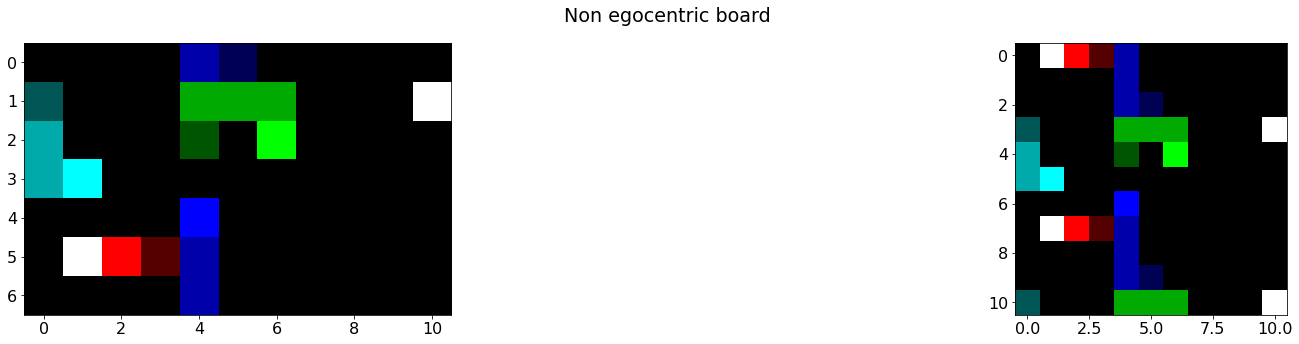

In [19]:
game_state = GameState(egocentric_board=False)
agent_idx = 0
game_state.reset()
for step_idx, step in enumerate(match):
    observation = step[0]['observation'].copy()
    observation['index'] = agent_idx
    game_state.update(observation, configuration)
    if step_idx:
        game_state.add_action(step[agent_idx]['action'])
    if not observation['geese'][agent_idx]:
        break

step_idx = 20
plt.suptitle('Non egocentric board')
plt.subplot(121)
plt.imshow(game_state.render_board(game_state.boards[step_idx][2:-2]))
plt.subplot(122)
plt.imshow(game_state.render_board(game_state.boards[step_idx]))

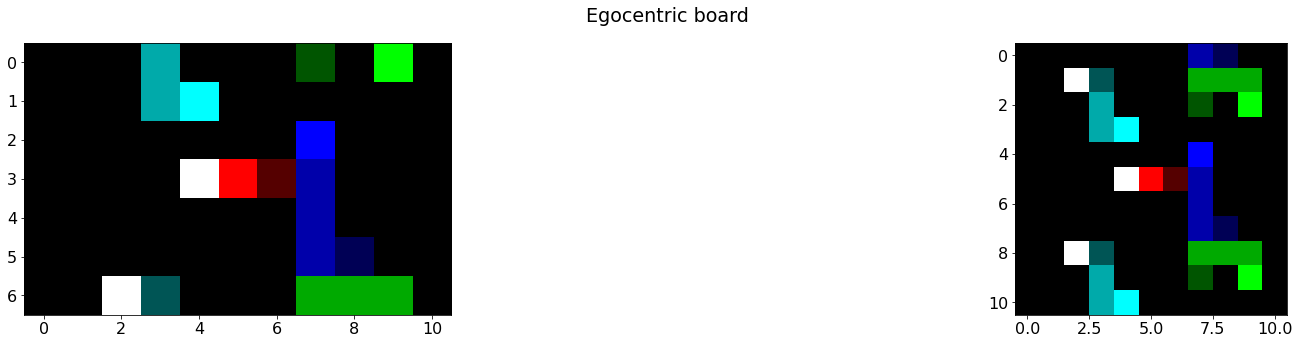

In [20]:
game_state = GameState(egocentric_board=True)
agent_idx = 0
game_state.reset()
for step_idx, step in enumerate(match):
    observation = step[0]['observation'].copy()
    observation['index'] = agent_idx
    game_state.update(observation, configuration)
    if step_idx:
        game_state.add_action(step[agent_idx]['action'])
    if not observation['geese'][agent_idx]:
        break

step_idx = 20
plt.suptitle('Egocentric board')
plt.subplot(121)
plt.imshow(game_state.render_board(game_state.boards[step_idx][2:-2]))
plt.subplot(122)
plt.imshow(game_state.render_board(game_state.boards[step_idx]))

Everything looks fine.

## Rotate board to forward is north

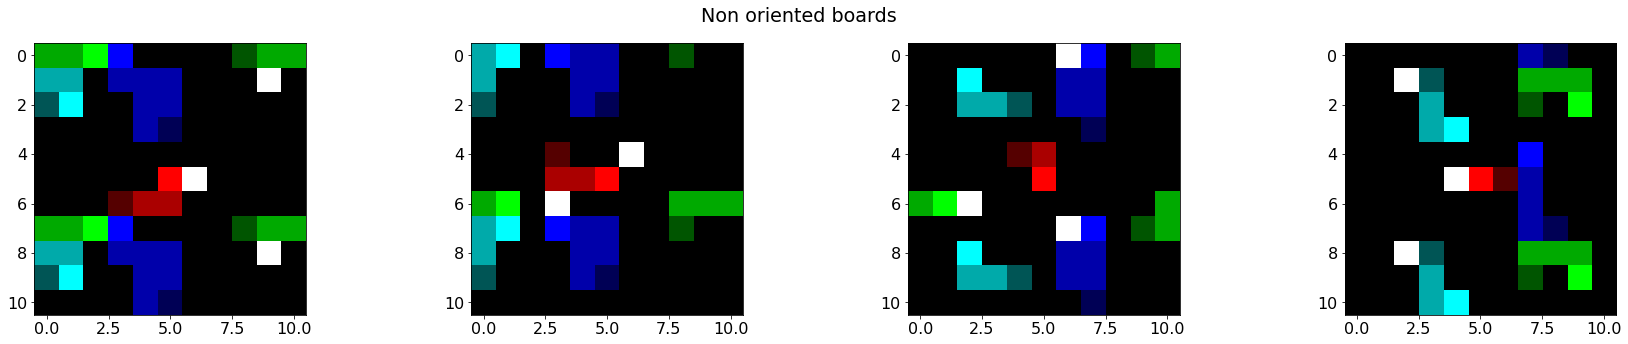

In [40]:
plt.suptitle('Non oriented boards')
step_idx_range = [27, 26, 24, 20]
for plot_idx, step_idx in enumerate(step_idx_range):
    plt.subplot(1, len(step_idx_range), plot_idx + 1)
    rendered_board = game_state.render_board(game_state.boards[step_idx])
    plt.imshow(rendered_board)

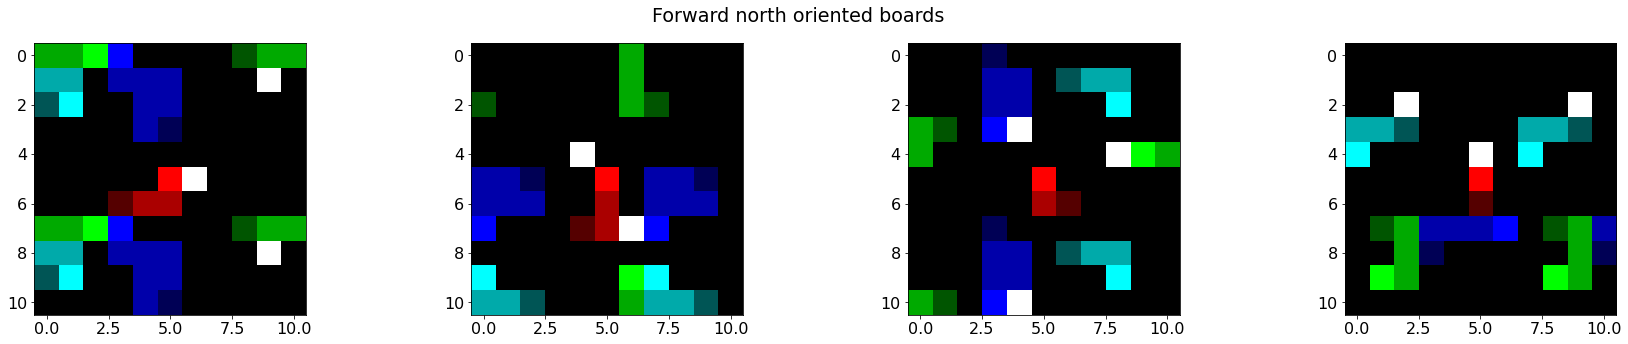

In [41]:
plt.suptitle('Forward north oriented boards')
step_idx_range = [27, 26, 24, 20]
for plot_idx, step_idx in enumerate(step_idx_range):
    plt.subplot(1, len(step_idx_range), plot_idx + 1)
    rendered_board = game_state.render_board(game_state.boards[step_idx])
    rendered_board = make_board_forward_north_oriented(rendered_board, ACTIONS[plot_idx])
    plt.imshow(rendered_board)

Looks pretty good, with this visualization 0 will mean rotate left, 1 forward and 2 rotate right. This simplifies the game enormously.

## Study saved match

Let's visualize a saved match to verify that everything is correct.

In [66]:
game_state = GameState()
data = dict(**np.load('../scripts/deep_q_learning/delete.npz'))
data.keys()

for key in data:
    print(key, data[key].shape)

boards (78, 11, 11, 17)
features (78, 9)
rewards (78, 3)
is_not_terminal (78, 3)
training_mask (78, 3)


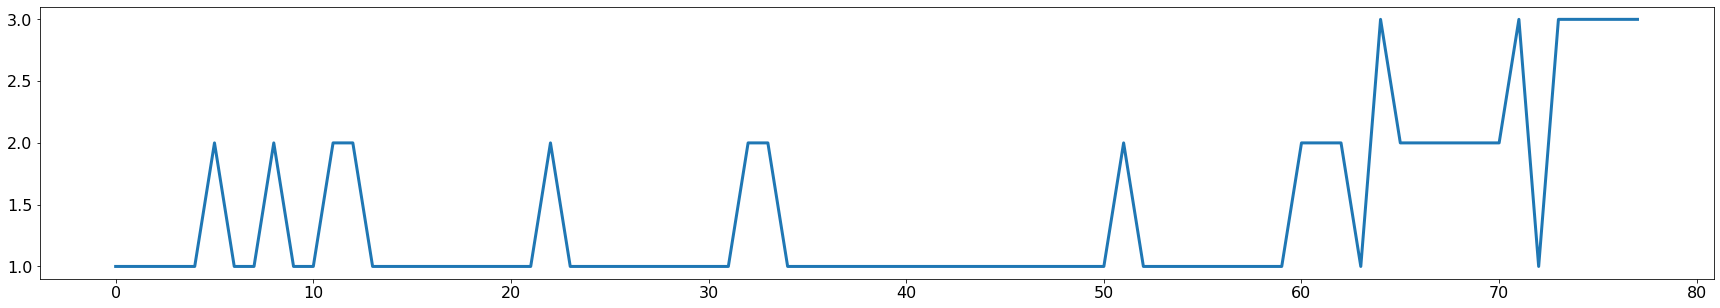

In [67]:
plt.plot(np.sum(data['training_mask'], axis=1))

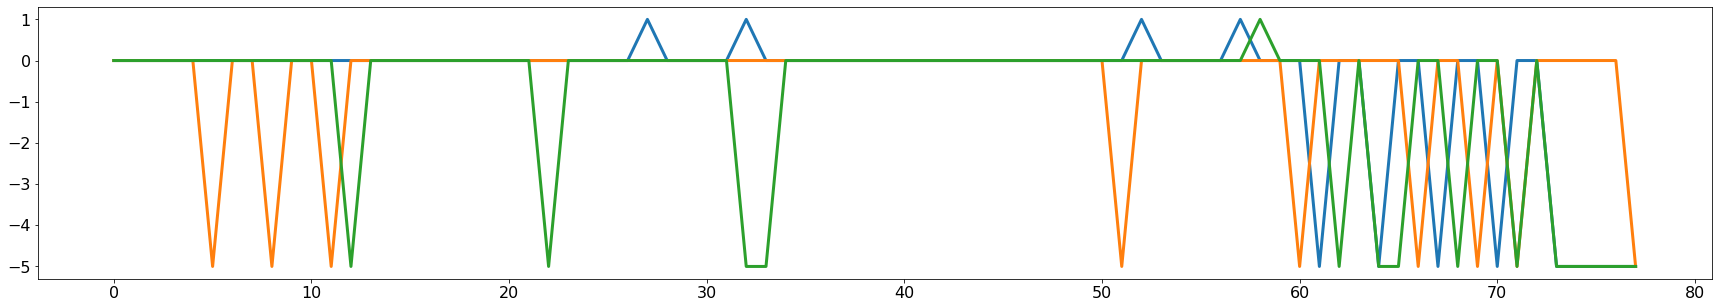

In [68]:
plt.plot(data['rewards'])

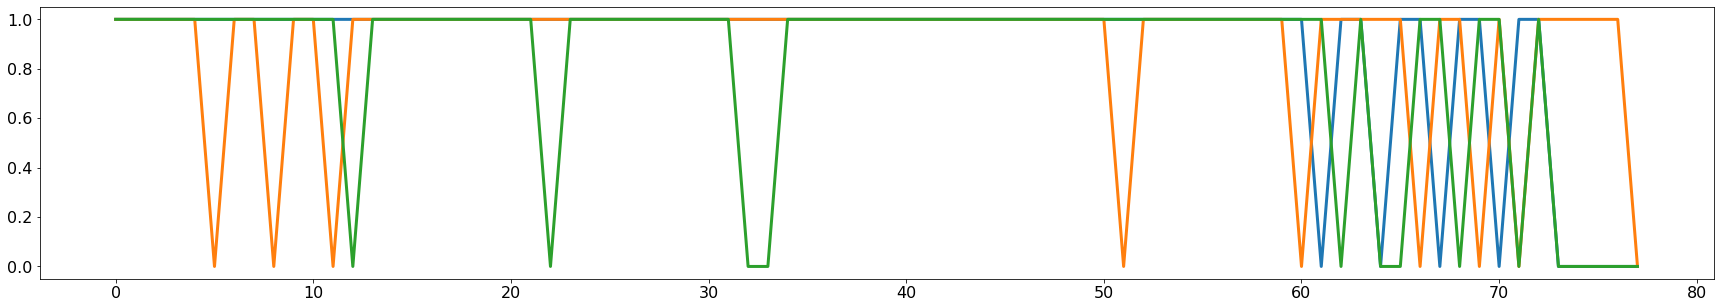

In [69]:
plt.plot(data['is_not_terminal'])

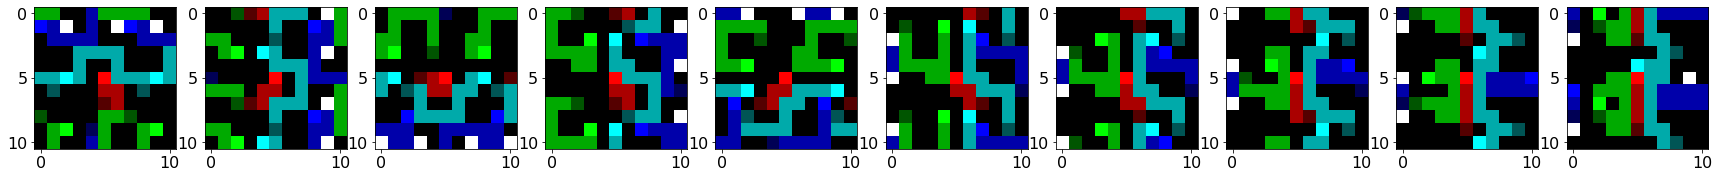

In [76]:
start = -10
step_range = np.arange(start, start + 10)
for plot_idx, step in enumerate(step_range):
    plt.subplot(1, len(step_range), plot_idx + 1)
    plt.imshow(game_state.render_board(data['boards'][step]))

In [79]:
data['rewards'][np.arange(start, start + 10)]

array([[ 0.,  0., -5.],
       [ 0., -5.,  0.],
       [-5.,  0.,  0.],
       [ 0., -5., -5.],
       [ 0.,  0.,  0.],
       [-5.,  0., -5.],
       [-5.,  0., -5.],
       [-5.,  0., -5.],
       [-5.,  0., -5.],
       [-5., -5., -5.]])

In [80]:
data['training_mask'][np.arange(start, start + 10)]

array([[1., 0., 1.],
       [1., 1., 0.],
       [1., 0., 1.],
       [1., 1., 1.],
       [0., 0., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [82]:
data['is_not_terminal'][np.arange(start, start + 10)]

array([[1., 1., 0.],
       [1., 0., 1.],
       [0., 1., 1.],
       [1., 0., 0.],
       [1., 1., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

Everything looks good.